# **Simple RNN Exercise 2: Hidden Units Experiment**

This excercise demonstrates how different hidden unit sizes affect Simple RNN performance for weather prediction.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(" EXERCISE 2: HIDDEN UNITS EXPERIMENT")
print("=" * 60)
print("Goal: Understand how hidden units affect Simple RNN performance")
print("We'll test hidden units: 16, 32, 64, 128")
print("=" * 60)

 EXERCISE 2: HIDDEN UNITS EXPERIMENT
Goal: Understand how hidden units affect Simple RNN performance
We'll test hidden units: 16, 32, 64, 128


**Data Generation Function (Same as Exercise 1)**

Purpose: Creates the same realistic synthetic weather data as Exercise 1 for consistent comparison.

In [2]:
def generate_weather_data(days=500):
    """Generate synthetic weather data with realistic patterns"""
    np.random.seed(42)
    data = []

    for i in range(days):
        # Season calculation (0: spring, 1: summer, 2: fall, 3: winter)
        season = int(i / 91) % 4

        # Base temperature by season
        base_temps = [15, 25, 10, 0]  # Spring, Summer, Fall, Winter
        base_temp = base_temps[season]

        # Add seasonal and daily variations
        seasonal_variation = 5 * np.sin(2 * np.pi * i / 365)
        daily_variation = 3 * np.sin(2 * np.pi * i / 30)  # Monthly cycle
        random_variation = np.random.normal(0, 2)

        temperature = base_temp + seasonal_variation + daily_variation + random_variation

        # Correlated weather variables
        humidity = np.clip(60 + (25 - temperature) * 0.8 + np.random.normal(0, 5), 0, 100)
        pressure = 1013 + np.random.normal(0, 15) + temperature * 0.1
        wind_speed = np.clip(8 + np.random.exponential(5) + abs(temperature - 15) * 0.1, 0, 30)

        data.append({
            'Day': i,
            'Temperature': temperature,
            'Humidity': humidity,
            'Pressure': pressure,
            'WindSpeed': wind_speed,
            'Season': season
        })

    return pd.DataFrame(data)

**Data Preparation Function (Fixed Sequence Length)**

Purpose: Same data preparation as Exercise 1, but it fix the sequence length at 7 days (a good performer from Exercise 1) and focus on varying hidden units.

In [3]:
def prepare_data_for_simple_rnn(data, sequence_length=7, feature_columns=None, target_column='Temperature'):
    """
     Prepare data for Simple RNN training
    For Exercise 2: We fix sequence_length=7 (from Exercise 1 insights) and vary hidden_units
    """
    if feature_columns is None:
        feature_columns = ['Temperature', 'Humidity', 'Pressure', 'WindSpeed']

    print(f" Preparing data with sequence_length={sequence_length}")
    print(f" Features: {feature_columns}")
    print(f" Target: {target_column}")

    # Extract features and target
    features = data[feature_columns].values
    target = data[target_column].values.reshape(-1, 1)

    # Normalize data
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()

    features_scaled = scaler_features.fit_transform(features)
    target_scaled = scaler_target.fit_transform(target)

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(features_scaled)):
        X.append(features_scaled[i-sequence_length:i])
        y.append(target_scaled[i])

    X = np.array(X)
    y = np.array(y)

    print(f" Data shape: X={X.shape}, y={y.shape}")
    print(f" Available samples: {len(X)}")

    return X, y, scaler_features, scaler_target

**Model Creation Function (Variable Hidden Units)**

Purpose: Creates Simple RNN models with different hidden unit sizes. Note the parameter count display to understand model complexity.

In [5]:
def create_simple_rnn_model(input_shape, hidden_units=32):
    """
     KEY FUNCTION: Create Simple RNN model with variable hidden units
    This is where we modify hidden_units for Exercise 2
    """
    print(f" Creating Simple RNN model:")
    print(f"   - Input shape: {input_shape}")
    print(f"   - Hidden units: {hidden_units}")

    model = Sequential([
        SimpleRNN(hidden_units,
                 input_shape=input_shape,
                 activation='tanh',
                 return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    # Display model parameters count
    total_params = model.count_params()
    print(f"   - Total parameters: {total_params:,}")

    return model

**Training and Evaluation Function (Enhanced with Overfitting Detection)**

Purpose: Enhanced training function that tracks overfitting by comparing final training and validation losses. More epochs allow us to see overfitting effects better.

In [6]:
def train_and_evaluate_model(X, y, scaler_target, hidden_units, epochs=50):
    """
    Train model and return performance metrics
    Enhanced for Exercise 2: More epochs and overfitting detection
    """

    # Split data (80% train, 20% test)
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    print(f" Train samples: {len(X_train)}, Test samples: {len(X_test)}")

    # Create and train model
    model = create_simple_rnn_model(input_shape=(X.shape[1], X.shape[2]), hidden_units=hidden_units)

    print(f" Training model for {epochs} epochs...")
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        verbose=0,  # Reduced verbosity
        shuffle=False  # Keep time series order
    )

    # Make predictions
    predictions_scaled = model.predict(X_test, verbose=0)
    predictions = scaler_target.inverse_transform(predictions_scaled)
    y_test_denorm = scaler_target.inverse_transform(y_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test_denorm, predictions)
    rmse = np.sqrt(mean_squared_error(y_test_denorm, predictions))

    # Calculate overfitting metric (final train vs validation loss)
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    overfitting_ratio = final_val_loss / final_train_loss

    print(f"✅ Model Performance:")
    print(f"   Mean Absolute Error: {mae:.3f}")
    print(f"   Root Mean Square Error: {rmse:.3f}")
    print(f"   Overfitting Ratio: {overfitting_ratio:.2f} (Val/Train Loss)")

    return mae, rmse, overfitting_ratio, history, predictions, y_test_denorm

**Generate Weather Data**

Purpose: Generates data and prepares it with a fixed sequence length of 7 days (based on Exercise 1 insights).

In [7]:
# Generate weather data (same as Exercise 1)
print(" Generating synthetic weather data...")
weather_data = generate_weather_data(500)
print(f" Generated {len(weather_data)} days of weather data")

# Prepare data with fixed sequence length from Exercise 1 insights
print(" Using sequence_length=7 (good performer from Exercise 1)")
X, y, scaler_features, scaler_target = prepare_data_for_simple_rnn(
    weather_data,
    sequence_length=7,  # Fixed from Exercise 1
    feature_columns=['Temperature', 'Humidity', 'Pressure', 'WindSpeed']
)

 Generating synthetic weather data...
 Generated 500 days of weather data
 Using sequence_length=7 (good performer from Exercise 1)
 Preparing data with sequence_length=7
 Features: ['Temperature', 'Humidity', 'Pressure', 'WindSpeed']
 Target: Temperature
 Data shape: X=(493, 7, 4), y=(493, 1)
 Available samples: 493


**Main Experiment Loop (Hidden Units)**

Purpose: The core experiment that systematically tests different hidden unit sizes (16, 32, 64, 128) and stores comprehensive results including overfitting metrics.

In [8]:
# Exercise 2: Test different hidden units
hidden_units_list = [16, 32, 64, 128]
results = {}

print(f"\n TESTING DIFFERENT HIDDEN UNITS")
print("=" * 50)

for hidden_units in hidden_units_list:
    print(f"\n TESTING HIDDEN UNITS: {hidden_units}")
    print("-" * 40)

    # Train and evaluate with current hidden units
    mae, rmse, overfitting_ratio, history, predictions, actual = train_and_evaluate_model(
        X, y, scaler_target, hidden_units, epochs=50
    )

    # Store results
    results[hidden_units] = {
        'mae': mae,
        'rmse': rmse,
        'overfitting_ratio': overfitting_ratio,
        'history': history,
        'predictions': predictions[:50],  # Store first 50 predictions for plotting
        'actual': actual[:50],
        'total_params': None  # Will be filled after model creation
    }

    print(f"✅ Completed hidden units {hidden_units}")

print(f"\n All hidden unit experiments completed!")


 TESTING DIFFERENT HIDDEN UNITS

 TESTING HIDDEN UNITS: 16
----------------------------------------
 Train samples: 394, Test samples: 99
 Creating Simple RNN model:
   - Input shape: (7, 4)
   - Hidden units: 16
   - Total parameters: 625
 Training model for 50 epochs...
✅ Model Performance:
   Mean Absolute Error: 3.183
   Root Mean Square Error: 4.264
   Overfitting Ratio: 0.67 (Val/Train Loss)
✅ Completed hidden units 16

 TESTING HIDDEN UNITS: 32
----------------------------------------
 Train samples: 394, Test samples: 99
 Creating Simple RNN model:
   - Input shape: (7, 4)
   - Hidden units: 32
   - Total parameters: 1,729
 Training model for 50 epochs...
✅ Model Performance:
   Mean Absolute Error: 2.937
   Root Mean Square Error: 3.809
   Overfitting Ratio: 1.02 (Val/Train Loss)
✅ Completed hidden units 32

 TESTING HIDDEN UNITS: 64
----------------------------------------
 Train samples: 394, Test samples: 99
 Creating Simple RNN model:
   - Input shape: (7, 4)
   - Hidden 

✅ Model Performance:
   Mean Absolute Error: 2.502
   Root Mean Square Error: 3.393
   Overfitting Ratio: 1.23 (Val/Train Loss)
✅ Completed hidden units 64

 TESTING HIDDEN UNITS: 128
----------------------------------------
 Train samples: 394, Test samples: 99
 Creating Simple RNN model:
   - Input shape: (7, 4)
   - Hidden units: 128
   - Total parameters: 19,105
 Training model for 50 epochs...
✅ Model Performance:
   Mean Absolute Error: 3.049
   Root Mean Square Error: 3.951
   Overfitting Ratio: 1.65 (Val/Train Loss)
✅ Completed hidden units 128

 All hidden unit experiments completed!


**Results Comparison Table (Enhanced)**

Purpose: Creates a comprehensive comparison table showing MAE, RMSE, overfitting status, and performance improvements for different hidden unit sizes.

In [9]:
# Compare results
print("\n" + "=" * 80)
print(" EXERCISE 2 RESULTS: HIDDEN UNITS COMPARISON")
print("=" * 80)

print(f"{'Hidden Units':<12} {'MAE':<8} {'RMSE':<8} {'Overfitting':<12} {'Improvement':<12}")
print("-" * 75)

base_mae = None
for hidden_units, metrics in results.items():
    if base_mae is None:
        base_mae = metrics['mae']
        improvement = "Baseline"
    else:
        improvement = f"{((base_mae - metrics['mae']) / base_mae * 100):+.1f}%"

    overfitting_status = "Good" if metrics['overfitting_ratio'] < 1.2 else "Moderate" if metrics['overfitting_ratio'] < 1.5 else "High"

    print(f"{hidden_units:<12} {metrics['mae']:<8.3f} {metrics['rmse']:<8.3f} {overfitting_status:<12} {improvement:<12}")


 EXERCISE 2 RESULTS: HIDDEN UNITS COMPARISON
Hidden Units MAE      RMSE     Overfitting  Improvement 
---------------------------------------------------------------------------
16           3.183    4.264    Good         Baseline    
32           2.937    3.809    Good         +7.7%       
64           2.502    3.393    Moderate     +21.4%      
128          3.049    3.951    High         +4.2%       


**Comprehensive Visualizations**

Purpose: Creates comprehensive visualizations showing performance trends, overfitting analysis, training dynamics, and the relationship between model complexity and performance.

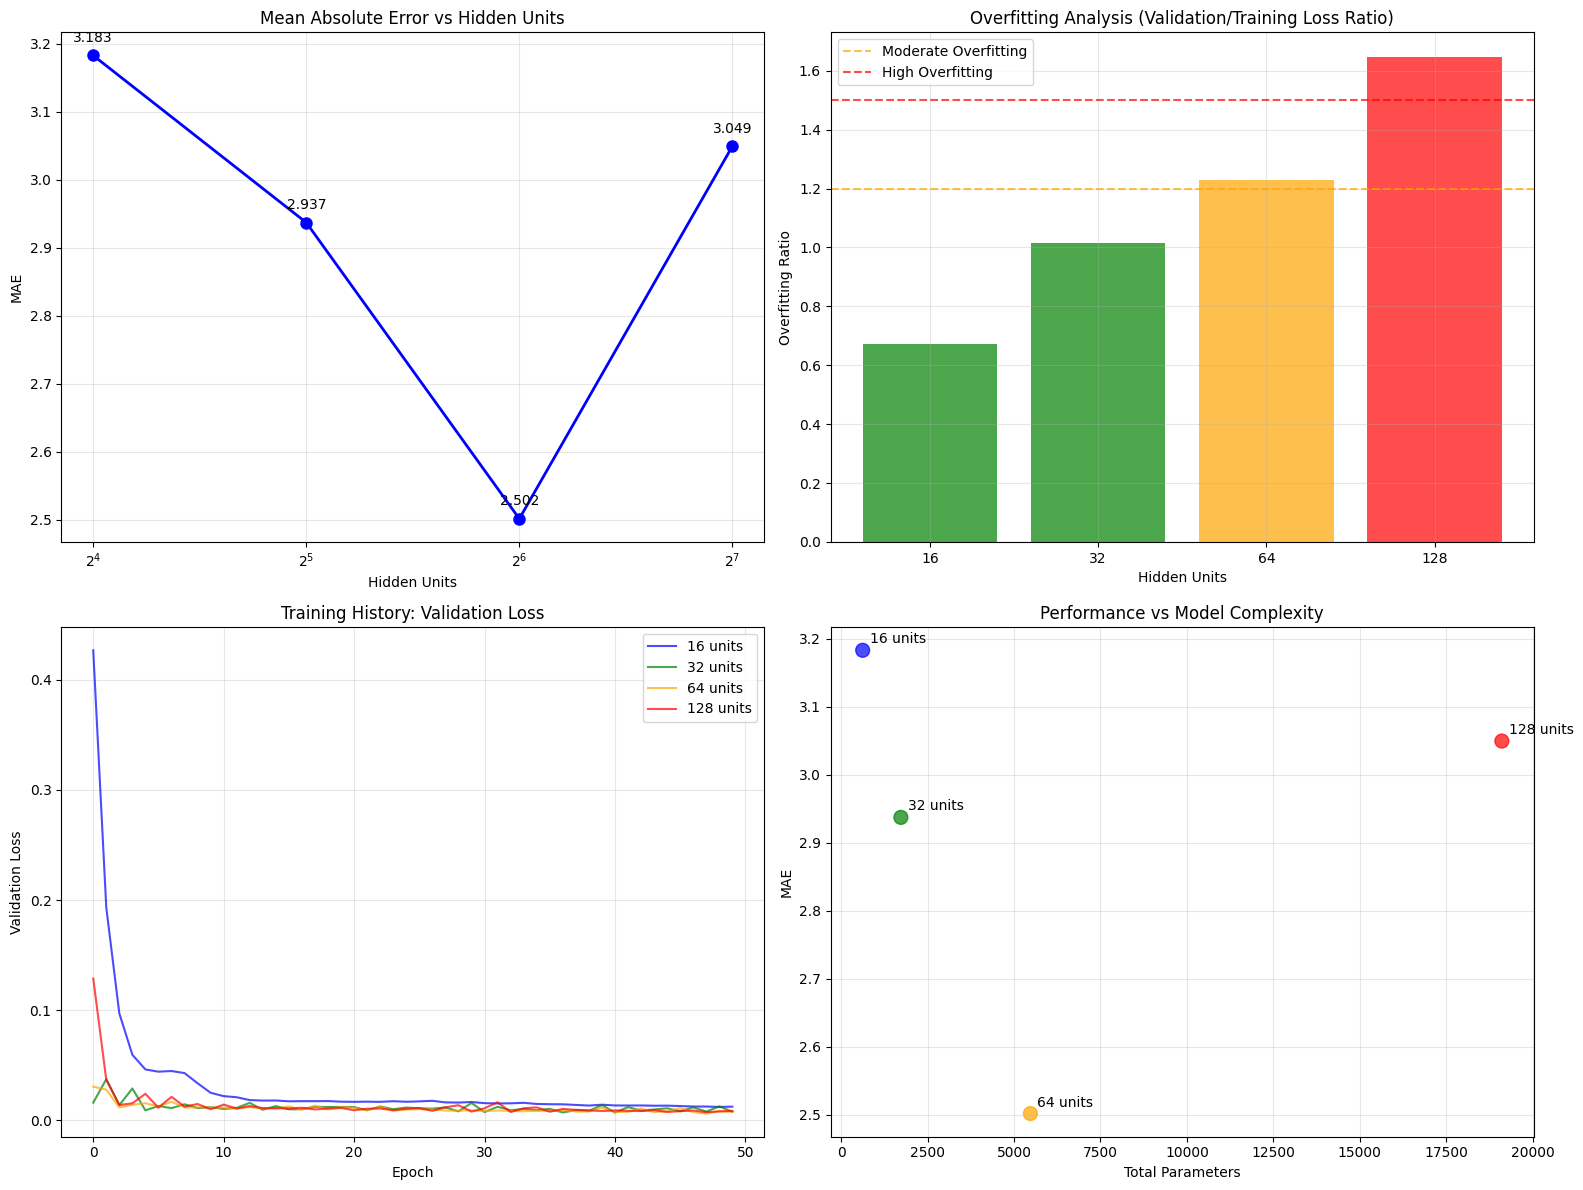

In [10]:
# Plot results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: MAE vs Hidden Units
hidden_units_vals = list(results.keys())
maes = [results[hu]['mae'] for hu in hidden_units_vals]
rmses = [results[hu]['rmse'] for hu in hidden_units_vals]
overfitting_ratios = [results[hu]['overfitting_ratio'] for hu in hidden_units_vals]

ax1.plot(hidden_units_vals, maes, 'bo-', linewidth=2, markersize=8)
ax1.set_title('Mean Absolute Error vs Hidden Units')
ax1.set_xlabel('Hidden Units')
ax1.set_ylabel('MAE')
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log', base=2)
for i, v in enumerate(maes):
    ax1.text(hidden_units_vals[i], v + 0.02, f'{v:.3f}', ha='center')

# Plot 2: Overfitting Analysis
colors = ['green' if ratio < 1.2 else 'orange' if ratio < 1.5 else 'red' for ratio in overfitting_ratios]
bars = ax2.bar(range(len(hidden_units_vals)), overfitting_ratios, color=colors, alpha=0.7)
ax2.set_title('Overfitting Analysis (Validation/Training Loss Ratio)')
ax2.set_xlabel('Hidden Units')
ax2.set_ylabel('Overfitting Ratio')
ax2.set_xticks(range(len(hidden_units_vals)))
ax2.set_xticklabels(hidden_units_vals)
ax2.axhline(y=1.2, color='orange', linestyle='--', alpha=0.7, label='Moderate Overfitting')
ax2.axhline(y=1.5, color='red', linestyle='--', alpha=0.7, label='High Overfitting')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Training History Comparison
ax3.set_title('Training History: Validation Loss')
colors = ['blue', 'green', 'orange', 'red']
for i, (hidden_units, metrics) in enumerate(results.items()):
    ax3.plot(metrics['history'].history['val_loss'],
            label=f'{hidden_units} units',
            color=colors[i], alpha=0.7)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Validation Loss')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Performance vs Model Complexity
# Calculate approximate parameter counts
param_counts = []
for hu in hidden_units_vals:
    # SimpleRNN params: (input_features + hidden_units + 1) * hidden_units
    # Dense layer params: (hidden_units + 1) * 16 + (16 + 1) * 1
    rnn_params = (4 + hu + 1) * hu  # 4 input features
    dense_params = (hu + 1) * 16 + (16 + 1) * 1
    total_params = rnn_params + dense_params
    param_counts.append(total_params)

ax4.scatter(param_counts, maes, s=100, alpha=0.7, c=colors)
ax4.set_title('Performance vs Model Complexity')
ax4.set_xlabel('Total Parameters')
ax4.set_ylabel('MAE')
ax4.grid(True, alpha=0.3)
for i, hu in enumerate(hidden_units_vals):
    ax4.annotate(f'{hu} units', (param_counts[i], maes[i]),
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

**Detailed Analysis and Insights**

Purpose: Provides comprehensive analysis identifying the best performing models, overfitting patterns, and key insights about the relationship between model capacity and performance.

In [11]:
# Detailed Analysis
print("\n" + "=" * 60)
print(" EXERCISE 2 ANALYSIS & INSIGHTS")
print("=" * 60)

# Find best and worst performers
best_hu = min(results.keys(), key=lambda k: results[k]['mae'])
worst_hu = max(results.keys(), key=lambda k: results[k]['mae'])

# Find least overfitted model
least_overfitted = min(results.keys(), key=lambda k: results[k]['overfitting_ratio'])
most_overfitted = max(results.keys(), key=lambda k: results[k]['overfitting_ratio'])

print(f"✅ Best performing hidden units: {best_hu}")
print(f"   - MAE: {results[best_hu]['mae']:.3f}")
print(f"   - RMSE: {results[best_hu]['rmse']:.3f}")
print(f"   - Overfitting Ratio: {results[best_hu]['overfitting_ratio']:.2f}")

print(f"\n Worst performing hidden units: {worst_hu}")
print(f"   - MAE: {results[worst_hu]['mae']:.3f}")
print(f"   - RMSE: {results[worst_hu]['rmse']:.3f}")
print(f"   - Overfitting Ratio: {results[worst_hu]['overfitting_ratio']:.2f}")

print(f"\n Least overfitted model: {least_overfitted} units")
print(f"   - Overfitting Ratio: {results[least_overfitted]['overfitting_ratio']:.2f}")

print(f"\n Most overfitted model: {most_overfitted} units")
print(f"   - Overfitting Ratio: {results[most_overfitted]['overfitting_ratio']:.2f}")

improvement = ((results[worst_hu]['mae'] - results[best_hu]['mae']) / results[worst_hu]['mae']) * 100
print(f"\n Performance improvement: {improvement:.1f}% (best vs worst)")

print(f"\n KEY INSIGHTS:")
print(f"   🔹 Hidden units significantly affect model performance")
print(f"   🔹 More units = higher capacity but risk of overfitting")
print(f"   🔹 Optimal hidden units for this problem: {best_hu}")
print(f"   🔹 Overfitting becomes noticeable with {most_overfitted} units")

print(f"\n LEARNING POINTS:")
print(f"    -Model capacity is a critical hyperparameter")
print(f"    -Need to balance underfitting vs overfitting")
print(f"    -More parameters ≠ always better performance")
print(f"    -Validation monitoring helps detect overfitting")
print(f"   -Simple problems may not need complex models")

print(f"\n EXERCISE 2 COMPLETED!")



 EXERCISE 2 ANALYSIS & INSIGHTS
✅ Best performing hidden units: 64
   - MAE: 2.502
   - RMSE: 3.393
   - Overfitting Ratio: 1.23

 Worst performing hidden units: 16
   - MAE: 3.183
   - RMSE: 4.264
   - Overfitting Ratio: 0.67

 Least overfitted model: 16 units
   - Overfitting Ratio: 0.67

 Most overfitted model: 128 units
   - Overfitting Ratio: 1.65

 Performance improvement: 21.4% (best vs worst)

 KEY INSIGHTS:
   🔹 Hidden units significantly affect model performance
   🔹 More units = higher capacity but risk of overfitting
   🔹 Optimal hidden units for this problem: 64
   🔹 Overfitting becomes noticeable with 128 units

 LEARNING POINTS:
    -Model capacity is a critical hyperparameter
    -Need to balance underfitting vs overfitting
    -More parameters ≠ always better performance
    -Validation monitoring helps detect overfitting
   -Simple problems may not need complex models

🎓 EXERCISE 2 COMPLETED!
